# Data download and processing from Swissprot

Downloaded the data on 01 May 2024. 254,929 results filtering for "Catalytic activity" and Reviewed "Swiss-Prot".  

Selected download TSV and the columns, Seqeunce (under Sequences tab), EC number (under Function).

Unzipped the downloaded file.

## 1. Protein to EC processing


In [1]:
import pandas as pd

swissprot = pd.read_csv('data/uniprot/uniprotkb_AND_reviewed_true_AND_protein_2024_05_01.tsv', sep='\t')
swissprot

FileNotFoundError: [Errno 2] No such file or directory: 'data/uniprot/uniprotkb_AND_reviewed_true_AND_protein_2024_05_01.tsv'

In [2]:
# Filter to only include sequneces < 512
swissprot = swissprot[swissprot['Length'] < 512]
swissprot

NameError: name 'swissprot' is not defined

Explode out EC number so each EC has it's own row

In [3]:
# Drop rows that don't have an ec number
swissprot = swissprot[swissprot['EC number'].notna()]
print(len(swissprot))
# Now expand out the ones we have left
swissprot['EC number'] = [ec.split(';') for ec in swissprot['EC number']]
swissprot = swissprot.explode('EC number')
# Clean the EC numbers
swissprot['EC number'] = [ec.replace(' ', '') for ec in swissprot['EC number']]
swissprot

199220


/var/folders/gq/6ljhmvm1713fykdjqbl188pm0000gn/T/ipykernel_34484/1265130750.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['EC number'] = [ec.split(';') for ec in df['EC number']]


,Entry,Entry Name,Sequence,EC number,Length
0,A0A009IHW8,ABTIR_ACIB9,MSLEQKKGADIISKILQIQNSIGKTTSPSTLKTKLSEISRKEQENA...,3.2.2.-,269
0,A0A009IHW8,ABTIR_ACIB9,MSLEQKKGADIISKILQIQNSIGKTTSPSTLKTKLSEISRKEQENA...,3.2.2.6,269
3,A0A024SC78,CUTI1_HYPJR,MRSLAILTTLLAGHAFAYPKPAPQSVNRRDWPSINEFLSELAKVMP...,3.1.1.74,248
4,A0A024SH76,GUX2_HYPJR,MIVGILTTLATLATLAASVPLEERQACSSVWGQCGGQNWSGPTCCA...,3.2.1.91,471
6,A0A059TC02,CCR1_PETHY,MRSVSGQVVCVTGAGGFIASWLVKILLEKGYTVRGTVRNPDDPKNG...,1.2.1.44,333
...,...,...,...,...,...
254921,P83855,ACLP_MOUSE,GVYMEIGRCRXEAXRRRKEAV,4.6.1.1,21
254922,P85957,PER_PSEMZ,AMAGTATVQGQGTR,1.11.1.7,14
254923,Q05115,AMDA_BORBO,MQQASTPTIGMIVPPAAGLVPADGARLYPDLPFIASGLGLGSVTPE...,4.1.1.76,240
254927,Q94MV8,VG56_BPLZ5,MAHFNECAHLIEGVDKANRAYAENIMHNIDPLQVMLDMQRHLQIRL...,3.6.1.12,172


In [3]:
#swissprot.to_csv('data/uniprot/processed.csv', index=False)
swissprot = pd.read_csv('processed.csv')
swissprot

,Entry,Entry Name,Sequence,EC number,Length
0,A0A009IHW8,ABTIR_ACIB9,MSLEQKKGADIISKILQIQNSIGKTTSPSTLKTKLSEISRKEQENA...,3.2.2.-,269
1,A0A009IHW8,ABTIR_ACIB9,MSLEQKKGADIISKILQIQNSIGKTTSPSTLKTKLSEISRKEQENA...,3.2.2.6,269
2,A0A024SC78,CUTI1_HYPJR,MRSLAILTTLLAGHAFAYPKPAPQSVNRRDWPSINEFLSELAKVMP...,3.1.1.74,248
3,A0A024SH76,GUX2_HYPJR,MIVGILTTLATLATLAASVPLEERQACSSVWGQCGGQNWSGPTCCA...,3.2.1.91,471
4,A0A059TC02,CCR1_PETHY,MRSVSGQVVCVTGAGGFIASWLVKILLEKGYTVRGTVRNPDDPKNG...,1.2.1.44,333
...,...,...,...,...,...
213086,P83855,ACLP_MOUSE,GVYMEIGRCRXEAXRRRKEAV,4.6.1.1,21
213087,P85957,PER_PSEMZ,AMAGTATVQGQGTR,1.11.1.7,14
213088,Q05115,AMDA_BORBO,MQQASTPTIGMIVPPAAGLVPADGARLYPDLPFIASGLGLGSVTPE...,4.1.1.76,240
213089,Q94MV8,VG56_BPLZ5,MAHFNECAHLIEGVDKANRAYAENIMHNIDPLQVMLDMQRHLQIRL...,3.6.1.12,172


* Filter to a certain sequence length?
* Drop duplicates
* Remove EC numbers with dash

In [6]:
swissprot = swissprot[swissprot['Length'] >= 100 ]
swissprot = swissprot.drop_duplicates(subset=['Sequence', 'EC number'])
swissprot = swissprot[~swissprot['EC number'].str.contains('-')]
swissprot

,Entry,Entry Name,Sequence,EC number,Length
1,A0A009IHW8,ABTIR_ACIB9,MSLEQKKGADIISKILQIQNSIGKTTSPSTLKTKLSEISRKEQENA...,3.2.2.6,269
2,A0A024SC78,CUTI1_HYPJR,MRSLAILTTLLAGHAFAYPKPAPQSVNRRDWPSINEFLSELAKVMP...,3.1.1.74,248
3,A0A024SH76,GUX2_HYPJR,MIVGILTTLATLATLAASVPLEERQACSSVWGQCGGQNWSGPTCCA...,3.2.1.91,471
4,A0A059TC02,CCR1_PETHY,MRSVSGQVVCVTGAGGFIASWLVKILLEKGYTVRGTVRNPDDPKNG...,1.2.1.44,333
5,A0A061I403,FICD_CRIGR,MPMASVIAVAEPKWISVWGRFLWLTLLSMALGSLLALLLPLGAVEE...,2.7.7.108,455
...,...,...,...,...,...
213078,P36352,POLR_PHMV,VIVGTPPISPNWPAIKDLLHLKFKTEITSSPLFCGYYLSPAGCIRN...,2.7.7.48,178
213079,P39262,VG56_BPT4,MAHFNECAHLIEGVDKAQNEYWDILGDEKDPLQVMLDMQRFLQIRL...,3.6.1.12,171
213088,Q05115,AMDA_BORBO,MQQASTPTIGMIVPPAAGLVPADGARLYPDLPFIASGLGLGSVTPE...,4.1.1.76,240
213089,Q94MV8,VG56_BPLZ5,MAHFNECAHLIEGVDKANRAYAENIMHNIDPLQVMLDMQRHLQIRL...,3.6.1.12,172


### Comparison to the dataset used in CLEAN

In [7]:
clean_df = pd.read_csv('raw_data/CLEAN_split100.tsv', sep='\t')
clean_df = clean_df.drop_duplicates(subset=['Sequence', 'EC number'])
clean_df

,Entry,EC number,Sequence
0,P51451,2.7.10.2,MGLVSSKKPDKEKPIKEKDKGQWSPLKVSAQDKDAPPLPPLVVFNH...
1,C7C422,3.5.2.6,MELPNIMHPVAKLSTALAAALMLSGCMPGEIRPTIGQQMETGDQRF...
2,Q07457,2.3.2.27,MTAEPATKKIKLELSDPSEPLTQSDVIAFQKEALFRCINRRRVDFE...
3,Q07009,3.4.22.53,MAGIAMKLAKDREAAEGLGSHERAIKYLNQDYETLRNECLEAGALF...
4,Q9TTH8,3.4.22.54,MPTVISASVAPRTGAEPRSPGPIAQAAQGKGTEAGGGNPSGIYSAI...
...,...,...,...
227357,Q97HD1,3.1.11.6,MPSKKESYESMIKELEKIVSSMENEELPLEEAMKNYEDGVKLCDKL...
227358,A0A140CUL9,1.1.99.13,MAENNTYDAIVIGSGISGGWATKELTEKGLKTLMLERGRNIEHVKD...
227359,W6JQJ6,1.13.12.2,MNKNNRHPADGKKPITIFGPDFPFAFDDWLEHPAGLGSIPAARHGE...
227360,B3IVI7,3.5.1.30,MRIALYQGAPKPLDVPGNLQRLRHQAQLAAERGAQLLVCPEMFLTG...


In [8]:
clean_df['Length'] = [len(seq) for seq in clean_df['Sequence']]
clean_df = clean_df[clean_df['Length'] < 512]
clean_df = clean_df[clean_df['Length'] >= 100]
clean_df

,Entry,EC number,Sequence,Length
0,P51451,2.7.10.2,MGLVSSKKPDKEKPIKEKDKGQWSPLKVSAQDKDAPPLPPLVVFNH...,505
1,C7C422,3.5.2.6,MELPNIMHPVAKLSTALAAALMLSGCMPGEIRPTIGQQMETGDQRF...,270
6,P00917,4.2.1.1,MAHSDWGYDSPNGPZEWVKLYPIANGNNQSPIDIKTSETKHDTSLK...,261
7,Q9ULX7,4.2.1.1,MLFSALLLEVIWILAADGGQHWTYEGPHGQDHWPASYPECGNNAQS...,337
11,P10506,2.7.12.2,MFKRRRNPKGLVLNPNASVKSSDNDHKEELINNQKSFESNVEAFME...,340
...,...,...,...,...
227341,Q9KQH9,2.3.1.179,MSKRRVVVTGMGMLSPVGNTVESSWKALLAGQSGIVNIEHFDTTNF...,414
227352,Q11WK3,6.3.5.2,MTEKILILDFGSQYTQLIARRVRELNVYCEIHPYNKAPQIDGTVKG...,509
227354,B1KNT2,4.2.1.59,MSEQLNTMDIKEIMSFLPHRYPFLLIDRVLDYTPGETLHAIKNVTI...,152
227360,B3IVI7,3.5.1.30,MRIALYQGAPKPLDVPGNLQRLRHQAQLAAERGAQLLVCPEMFLTG...,264


## 2. Reaction to EC processing

In [9]:
ECreact = pd.read_csv('raw_data/ECReact.csv')
ECreact['rxn_smiles'] = ECreact['rxn_smiles'].str.split('|').str[0] + '>>' + ECreact['rxn_smiles'].str.split('>>').str[1]
ECreact.rename(columns={'rxn_smiles': 'Reaction', 'ec': 'EC number', 'source':'Source'}, inplace=True)
ECreact

,Reaction,EC number,Source
0,NC(=O)c1ccc[n+]([C@@H]2O[C@H](COP(=O)(O)OP(=O)...,1.2.1.8,brenda_reaction_smiles
1,C=C(C)CCOP(=O)([O-])OP(=O)([O-])[O-].CC(C)=CCO...,2.5.1.85,brenda_reaction_smiles
2,N.NC(=O)C1=CN([C@@H]2O[C@H](COP(=O)(O)OP(=O)(O...,1.4.1.4,brenda_reaction_smiles
3,NC(=O)C1=CN([C@@H]2O[C@H](COP(=O)(O)OP(=O)(O)O...,1.1.1.3,brenda_reaction_smiles
4,Cc1cn([C@H]2C[C@H](O)[C@@H](COP(=O)(O)OP(=O)(O...,2.7.7.9,brenda_reaction_smiles
...,...,...,...
62217,CCCCC/C=C\C/C=C\C/C=C\C/C=C\C/C=C\CCC(=O)O[C@@...,2.3.1.76,pathbank_reaction_smiles
62218,CCCCCCCCCCCC/C=C\CCCCCCCC(=O)OC[C@H](COP(=O)(O...,2.7.8.41,pathbank_reaction_smiles
62219,CCCCCCCCCCCCCCCCCC(=O)O[C@H](COC(=O)CCCCCCCCCC...,2.7.8.41,pathbank_reaction_smiles
62220,CCCCCC/C=C\CCCCCCCCCCCC(=O)O[C@H](COC(=O)CCCCC...,2.7.8.41,pathbank_reaction_smiles


In [10]:
enzymemap = pd.read_csv('raw_data/EnzymeMap.csv')
enzymemap.rename(columns={'ec_num': 'EC number', 'unmapped': 'Reaction', 'mapped': 'Mapped Reaction', 'orig_rxn_text':'Reaction Text'}, inplace=True)
enzymemap = enzymemap[['Reaction', 'Mapped Reaction', 'EC number', 'Reaction Text']]
enzymemap.drop_duplicates(subset=['Reaction', 'EC number'], inplace=True)
enzymemap

,Reaction,Mapped Reaction,EC number,Reaction Text
0,CC=O.NC(=O)C1=CN([C@@H]2O[C@H](COP(=O)(O)OP(=O...,[CH3:1][CH:2]=[O:3].[H+].[NH2:4][C:5](=[O:6])[...,1.1.1.1,acetaldehyde + NADH + H+ = ethanol + NAD+ {r}
1,CCO.NC(=O)c1ccc[n+]([C@@H]2O[C@H](COP(=O)(O)OP...,[CH3:1][CH2:2][OH:3].[NH2:4][C:5](=[O:6])[c:7]...,1.1.1.1,acetaldehyde + NADH + H+ = ethanol + NAD+ {r}
25,CC(=O)C=O.NC(=O)C1=CN([C@@H]2O[C@H](COP(=O)(O)...,[CH3:1][C:2](=[O:3])[CH:4]=[O:5].[H+].[NH2:6][...,1.1.1.1,methylglyoxal + NADH + H+ = acetol + NAD+ {r}
26,CC(=O)CO.NC(=O)c1ccc[n+]([C@@H]2O[C@H](COP(=O)...,[CH3:1][C:2](=[O:3])[CH2:4][OH:5].[NH2:6][C:7]...,1.1.1.1,methylglyoxal + NADH + H+ = acetol + NAD+ {r}
27,NC(=O)c1ccc[n+]([C@@H]2O[C@H](COP(=O)(O)OP(=O)...,[NH2:1][C:2](=[O:3])[c:4]1[cH:5][cH:6][cH:7][n...,1.1.1.1,2-dehydro-3-deoxy-D-gluconate + NADH + H+ = 4-...
...,...,...,...,...
349453,CC(C)=CCOP(=O)(O)OP(=O)(O)O.Nc1ncnc2c1ncn2[C@@...,[CH3:1][C:2]([CH3:3])=[CH:4][CH2:5][O:6][P:7](...,6.5.1.3,ATP + dimethylallyl diphosphate = dimethylally...
349454,CC(C)=CCC/C(C)=C/COP(=O)(O)OP(=O)(O)O.Nc1ncnc2...,[CH3:1][C:2]([CH3:3])=[CH:4][CH2:5][CH2:6]/[C:...,6.5.1.3,ATP + geranyl diphosphate = geranyl-triphospho...
349455,CC(C)=CCC/C(C)=C/COP(=O)(O)OP(=O)(O)OP(=O)(O)O...,[CH3:1][C:2]([CH3:3])=[CH:4][CH2:5][CH2:6]/[C:...,6.5.1.3,ATP + geranyl triphosphate = geranyl-tetraphos...
349456,C=C(C)CCOP(=O)(O)OP(=O)(O)O.Nc1ncnc2c1ncn2[C@@...,[CH2:1]=[C:2]([CH3:3])[CH2:4][CH2:5][O:6][P:7]...,6.5.1.3,ATP + isopentenyl diphosphate = adenosine 5'-i...


In [11]:
enzymemap.dropna(subset=['Mapped Reaction'])

,Reaction,Mapped Reaction,EC number,Reaction Text
0,CC=O.NC(=O)C1=CN([C@@H]2O[C@H](COP(=O)(O)OP(=O...,[CH3:1][CH:2]=[O:3].[H+].[NH2:4][C:5](=[O:6])[...,1.1.1.1,acetaldehyde + NADH + H+ = ethanol + NAD+ {r}
1,CCO.NC(=O)c1ccc[n+]([C@@H]2O[C@H](COP(=O)(O)OP...,[CH3:1][CH2:2][OH:3].[NH2:4][C:5](=[O:6])[c:7]...,1.1.1.1,acetaldehyde + NADH + H+ = ethanol + NAD+ {r}
25,CC(=O)C=O.NC(=O)C1=CN([C@@H]2O[C@H](COP(=O)(O)...,[CH3:1][C:2](=[O:3])[CH:4]=[O:5].[H+].[NH2:6][...,1.1.1.1,methylglyoxal + NADH + H+ = acetol + NAD+ {r}
26,CC(=O)CO.NC(=O)c1ccc[n+]([C@@H]2O[C@H](COP(=O)...,[CH3:1][C:2](=[O:3])[CH2:4][OH:5].[NH2:6][C:7]...,1.1.1.1,methylglyoxal + NADH + H+ = acetol + NAD+ {r}
27,NC(=O)c1ccc[n+]([C@@H]2O[C@H](COP(=O)(O)OP(=O)...,[NH2:1][C:2](=[O:3])[c:4]1[cH:5][cH:6][cH:7][n...,1.1.1.1,2-dehydro-3-deoxy-D-gluconate + NADH + H+ = 4-...
...,...,...,...,...
349453,CC(C)=CCOP(=O)(O)OP(=O)(O)O.Nc1ncnc2c1ncn2[C@@...,[CH3:1][C:2]([CH3:3])=[CH:4][CH2:5][O:6][P:7](...,6.5.1.3,ATP + dimethylallyl diphosphate = dimethylally...
349454,CC(C)=CCC/C(C)=C/COP(=O)(O)OP(=O)(O)O.Nc1ncnc2...,[CH3:1][C:2]([CH3:3])=[CH:4][CH2:5][CH2:6]/[C:...,6.5.1.3,ATP + geranyl diphosphate = geranyl-triphospho...
349455,CC(C)=CCC/C(C)=C/COP(=O)(O)OP(=O)(O)OP(=O)(O)O...,[CH3:1][C:2]([CH3:3])=[CH:4][CH2:5][CH2:6]/[C:...,6.5.1.3,ATP + geranyl triphosphate = geranyl-tetraphos...
349456,C=C(C)CCOP(=O)(O)OP(=O)(O)O.Nc1ncnc2c1ncn2[C@@...,[CH2:1]=[C:2]([CH3:3])[CH2:4][CH2:5][O:6][P:7]...,6.5.1.3,ATP + isopentenyl diphosphate = adenosine 5'-i...


### Append EC numbers that are covered by ECreact but not by EnzymeMap, to EnzymeMap

In [12]:
#find the EC numbers covered by ECreact but not by enzymemap
ECreact = ECreact[~ECreact['EC number'].str.contains('-')]
not_covered = ECreact[~ECreact['EC number'].isin(enzymemap['EC number'].unique())]
not_covered['EC number'].nunique()

2353

In [13]:
reaction2EC = pd.concat((enzymemap, not_covered[['Reaction', 'EC number']])).sort_values(by='EC number')
reaction2EC

,Reaction,Mapped Reaction,EC number,Reaction Text
0,CC=O.NC(=O)C1=CN([C@@H]2O[C@H](COP(=O)(O)OP(=O...,[CH3:1][CH:2]=[O:3].[H+].[NH2:4][C:5](=[O:6])[...,1.1.1.1,acetaldehyde + NADH + H+ = ethanol + NAD+ {r}
1172,CC(C)(C)OC(=O)N1CCC(=O)C1.NC(=O)C1=CN([C@@H]2O...,[CH3:1][C:2]([CH3:3])([CH3:4])[O:5][C:6](=[O:7...,1.1.1.1,N-tert-butoxycarbonyl-3-pyrrolidinone + NADH +...
1173,CC(C)(C)OC(=O)N1CC[C@H](O)C1.NC(=O)c1ccc[n+]([...,[CH3:1][C:2]([CH3:3])([CH3:4])[O:5][C:6](=[O:7...,1.1.1.1,N-tert-butoxycarbonyl-3-pyrrolidinone + NADH +...
1176,NC(=O)C1=CN([C@@H]2O[C@H](COP(=O)(O)OP(=O)(O)O...,[H+].[NH2:1][C:2](=[O:3])[C:4]1=[CH:5][N:6]([C...,1.1.1.1,p-nitrobenzyloxycarbonyl-3-pyrrolidinone + NAD...
1177,NC(=O)c1ccc[n+]([C@@H]2O[C@H](COP(=O)(O)OP(=O)...,[NH2:1][C:2](=[O:3])[c:4]1[cH:5][cH:6][cH:7][n...,1.1.1.1,p-nitrobenzyloxycarbonyl-3-pyrrolidinone + NAD...
...,...,...,...,...
15228,Nc1ncnc2c1ncn2[C@@H]1O[C@H](COP(=O)([O-])OP(=O...,NaN,7.6.2.j,NaN
21396,C[C@@]1(O)OC[C@H](O)C1(O)O.Nc1ncnc2c1ncn2[C@@H...,NaN,7.6.2.l,NaN
34012,*CS(=O)(=O)[O-].Nc1ncnc2c1ncn2[C@@H]1O[C@H](CO...,NaN,7.6.2.o,NaN
15541,Cc1ncc(C[n+]2csc(CCO)c2C)c(N)n1.Nc1ncnc2c1ncn2...,NaN,7.6.2.p,NaN


## 3. Filter protein2EC and reaction2EC to intersection of their EC numbers

In [27]:
swissprot = swissprot[swissprot['EC number'].isin(reaction2EC['EC number'].unique())]
swissprot

,Entry,Entry Name,Sequence,EC number,Length
1,A0A009IHW8,ABTIR_ACIB9,MSLEQKKGADIISKILQIQNSIGKTTSPSTLKTKLSEISRKEQENA...,3.2.2.6,269
2,A0A024SC78,CUTI1_HYPJR,MRSLAILTTLLAGHAFAYPKPAPQSVNRRDWPSINEFLSELAKVMP...,3.1.1.74,248
3,A0A024SH76,GUX2_HYPJR,MIVGILTTLATLATLAASVPLEERQACSSVWGQCGGQNWSGPTCCA...,3.2.1.91,471
4,A0A059TC02,CCR1_PETHY,MRSVSGQVVCVTGAGGFIASWLVKILLEKGYTVRGTVRNPDDPKNG...,1.2.1.44,333
10,A0A068J840,UGT1_PANGI,MKSELIFLPAPAIGHLVGMVEMAKLFISRHENLSVTVLIAKFYMDT...,2.4.1.363,475
...,...,...,...,...,...
213078,P36352,POLR_PHMV,VIVGTPPISPNWPAIKDLLHLKFKTEITSSPLFCGYYLSPAGCIRN...,2.7.7.48,178
213079,P39262,VG56_BPT4,MAHFNECAHLIEGVDKAQNEYWDILGDEKDPLQVMLDMQRFLQIRL...,3.6.1.12,171
213088,Q05115,AMDA_BORBO,MQQASTPTIGMIVPPAAGLVPADGARLYPDLPFIASGLGLGSVTPE...,4.1.1.76,240
213089,Q94MV8,VG56_BPLZ5,MAHFNECAHLIEGVDKANRAYAENIMHNIDPLQVMLDMQRHLQIRL...,3.6.1.12,172


In [25]:
swissprot[:20].to_csv('medium_reaction_test.csv', index=False)

In [18]:
#save the indices corresponding to unique proteins, for downstream use
unique_protein_indices = swissprot.reset_index().drop_duplicates(subset=['Sequence']).index
with open('unique_protein_indices.txt', 'w') as f:
    for index in unique_protein_indices:
        f.write(str(index) + '\n')

In [15]:
reaction2EC = reaction2EC[reaction2EC['EC number'].isin(swissprot['EC number'].unique())]
reaction2EC

,Reaction,Mapped Reaction,EC number,Reaction Text
0,CC=O.NC(=O)C1=CN([C@@H]2O[C@H](COP(=O)(O)OP(=O...,[CH3:1][CH:2]=[O:3].[H+].[NH2:4][C:5](=[O:6])[...,1.1.1.1,acetaldehyde + NADH + H+ = ethanol + NAD+ {r}
1172,CC(C)(C)OC(=O)N1CCC(=O)C1.NC(=O)C1=CN([C@@H]2O...,[CH3:1][C:2]([CH3:3])([CH3:4])[O:5][C:6](=[O:7...,1.1.1.1,N-tert-butoxycarbonyl-3-pyrrolidinone + NADH +...
1173,CC(C)(C)OC(=O)N1CC[C@H](O)C1.NC(=O)c1ccc[n+]([...,[CH3:1][C:2]([CH3:3])([CH3:4])[O:5][C:6](=[O:7...,1.1.1.1,N-tert-butoxycarbonyl-3-pyrrolidinone + NADH +...
1176,NC(=O)C1=CN([C@@H]2O[C@H](COP(=O)(O)OP(=O)(O)O...,[H+].[NH2:1][C:2](=[O:3])[C:4]1=[CH:5][N:6]([C...,1.1.1.1,p-nitrobenzyloxycarbonyl-3-pyrrolidinone + NAD...
1177,NC(=O)c1ccc[n+]([C@@H]2O[C@H](COP(=O)(O)OP(=O)...,[NH2:1][C:2](=[O:3])[c:4]1[cH:5][cH:6][cH:7][n...,1.1.1.1,p-nitrobenzyloxycarbonyl-3-pyrrolidinone + NAD...
...,...,...,...,...
34226,CC1=C2[N+]3=C(C=C4[N+]5=C(C(C)=C6N7[C@@H]8[C@H...,NaN,7.6.2.8,NaN
34223,CC1=C2[N+]3=C(C=C4[N+]5=C(C(C)=C6N7[C@H]([C@H]...,NaN,7.6.2.8,NaN
15471,C[N+]1(C)CCC[C@H]1C(=O)[O-].Nc1ncnc2c1ncn2[C@@...,NaN,7.6.2.9,NaN
644,Nc1ncnc2c1ncn2[C@@H]1O[C@H](COP(=O)(O)OP(=O)(O...,NaN,7.6.2.9,NaN


In [23]:
# reaction2EC[:20].to_csv('easy_reaction_test.csv', index=False)

In [22]:
# #save the indices corresponding to unique proteins, for downstream use
# import numpy as np
# indices = np.random.choice(reaction2EC.reset_index().index, 30, replace=False)
# with open('easy_reaction_train_indices.txt', 'w') as f:
#     for index in indices:
#         f.write(str(index) + '\n')

In [23]:
reaction2EC.to_csv('../processed_data/reaction2EC.csv', index=False)

## 4. Perform protein clustering using mmseqs

In [24]:
#generate a fasta file as input to mmseqs
with open('clustering/swissprot.fasta', 'w') as f:
    for index, row in swissprot.iterrows():
        f.write(f'>{row["Entry"]}\n{row["Sequence"]}\n')

In [25]:
!mmseqs easy-cluster clustering/swissprot.fasta clustering/clusterRes50 clustering/mmseqs_tmp --min-seq-id 0.5 -c 0.8 --cov-mode 1

easy-cluster clustering/swissprot.fasta clustering/clusterRes50 clustering/mmseqs_tmp --min-seq-id 0.5 -c 0.8 --cov-mode 1 

MMseqs Version:                     	15.6f452
Substitution matrix                 	aa:blosum62.out,nucl:nucleotide.out
Seed substitution matrix            	aa:VTML80.out,nucl:nucleotide.out
Sensitivity                         	4
k-mer length                        	0
Target search mode                  	0
k-score                             	seq:2147483647,prof:2147483647
Alphabet size                       	aa:21,nucl:5
Max sequence length                 	65535
Max results per query               	20
Split database                      	0
Split mode                          	2
Split memory limit                  	0
Coverage threshold                  	0.8
Coverage mode                       	1
Compositional bias                  	1
Compositional bias                  	1
Diagonal scoring                    	true
Exact k-mer matching                	0
Mask residu

In [26]:
!mmseqs easy-cluster clustering/swissprot.fasta clustering/clusterRes30 clustering/mmseqs_tmp --min-seq-id 0.3 -c 0.8 --cov-mode 1

easy-cluster clustering/swissprot.fasta clustering/clusterRes30 clustering/mmseqs_tmp --min-seq-id 0.3 -c 0.8 --cov-mode 1 

MMseqs Version:                     	15.6f452
Substitution matrix                 	aa:blosum62.out,nucl:nucleotide.out
Seed substitution matrix            	aa:VTML80.out,nucl:nucleotide.out
Sensitivity                         	4
k-mer length                        	0
Target search mode                  	0
k-score                             	seq:2147483647,prof:2147483647
Alphabet size                       	aa:21,nucl:5
Max sequence length                 	65535
Max results per query               	20
Split database                      	0
Split mode                          	2
Split memory limit                  	0
Coverage threshold                  	0.8
Coverage mode                       	1
Compositional bias                  	1
Compositional bias                  	1
Diagonal scoring                    	true
Exact k-mer matching                	0
Mask residu

23633
6958


,Entry,Entry Name,Sequence,EC number,Length,clusterRes50,clusterRes30
0,A0A009IHW8,ABTIR_ACIB9,MSLEQKKGADIISKILQIQNSIGKTTSPSTLKTKLSEISRKEQENA...,3.2.2.6,269,A0A009IHW8,A1AY86
1,A0A024SC78,CUTI1_HYPJR,MRSLAILTTLLAGHAFAYPKPAPQSVNRRDWPSINEFLSELAKVMP...,3.1.1.74,248,A0A024SC78,A0A024SC78
2,A0A024SH76,GUX2_HYPJR,MIVGILTTLATLATLAASVPLEERQACSSVWGQCGGQNWSGPTCCA...,3.2.1.91,471,G4MM92,G4MM92
3,A0A059TC02,CCR1_PETHY,MRSVSGQVVCVTGAGGFIASWLVKILLEKGYTVRGTVRNPDDPKNG...,1.2.1.44,333,Q9S9N9,P14721
4,A0A068J840,UGT1_PANGI,MKSELIFLPAPAIGHLVGMVEMAKLFISRHENLSVTVLIAKFYMDT...,2.4.1.363,475,Q2V6K0,Q40287
...,...,...,...,...,...,...,...
149783,P36352,POLR_PHMV,VIVGTPPISPNWPAIKDLLHLKFKTEITSSPLFCGYYLSPAGCIRN...,2.7.7.48,178,P36352,P36352
149784,P39262,VG56_BPT4,MAHFNECAHLIEGVDKAQNEYWDILGDEKDPLQVMLDMQRFLQIRL...,3.6.1.12,171,Q94MV8,Q94MV8
149785,Q05115,AMDA_BORBO,MQQASTPTIGMIVPPAAGLVPADGARLYPDLPFIASGLGLGSVTPE...,4.1.1.76,240,Q05115,Q05115
149786,Q94MV8,VG56_BPLZ5,MAHFNECAHLIEGVDKANRAYAENIMHNIDPLQVMLDMQRHLQIRL...,3.6.1.12,172,Q94MV8,Q94MV8


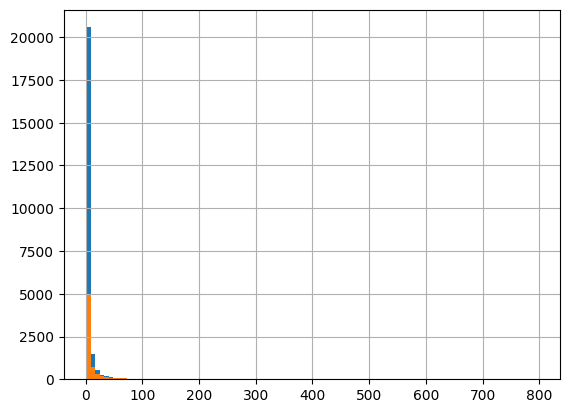

In [27]:
def process_clustering(name):
    clustering = pd.read_csv('clustering/{}_cluster.tsv'.format(name), delimiter='\t', header=None)
    #rename heading as cluster reference and id
    clustering.columns = [name, 'Entry']
    clustering.drop_duplicates(subset='Entry', keep='first', inplace=True)
    print(clustering[name].nunique())
    clustering[name].value_counts().hist(bins=100)
    return clustering

swissprot = swissprot[['Entry', 'Entry Name', 'Sequence', 'EC number', 'Length']]

cluster50 = process_clustering('clusterRes50')
cluster30 = process_clustering('clusterRes30')

swissprot = pd.merge(swissprot, cluster50, on='Entry', how='left')
swissprot = pd.merge(swissprot, cluster30, on='Entry', how='left')
swissprot

In [28]:
swissprot.to_csv('../processed_data/protein2EC.csv', index=False)

# Finally process textual description of EC numbers
This is optionally used in CREEP

In [28]:
#read ECtoGO.txt line by line
ECtoGO = open("raw_data/ECtoGO_raw.txt", "r")
ECtoGO_lines = ECtoGO.readlines()
ECtoGO.close()

#skip the first two lines
ECtoGO_lines = ECtoGO_lines[2:]
EC2desc = {}
for line in ECtoGO_lines:
    line = line.strip().split(">")
    EC = line[0][3:-1]
    desc = line[1].split(";")[0][4:-1]
    EC2desc[EC] = desc

def get_EC_desc(EC):
    num_dashes = EC.count('-')

    description_missing = False
    EC1 = '.'.join(EC.split('.')[:1])
    if EC1 + '.-.-.-' in EC2desc and num_dashes < 3:
        desc1 = EC2desc[EC1 + '.-.-.-']
    else:
         desc1 = ''
    EC2 = '.'.join(EC.split('.')[:2]) 
    if EC2 + '.-.-' in EC2desc and num_dashes < 2:
        desc2 = EC2desc[EC2 + '.-.-']
    else:
        desc2 = ''
    EC3 = '.'.join(EC.split('.')[:3])
    if EC3 + '.-' in EC2desc and num_dashes < 1:
        desc3 = EC2desc[EC3 + '.-']
    else:
        desc3 = ''
        
    if EC in EC2desc:
        desc4 = EC2desc[EC]
    else:
        description_missing = True
        desc4 = ''

    # if desc1 in desc2:
    #     desc1 = ''
    # if desc2 in desc3:
    #     desc2 = ''
    description = desc1 + '; ' + desc2 + '; ' + desc3 + '; ' + desc4
    description = description.replace(' ; ', ' ')
    description = description.replace(' ; ', ' ')
    description = description.replace(' ; ', ' ')
    description = description.replace(' activity', '')
    #if string starts with ;, replace with space
    if description[0] == ';':
        description = description[2:]
    if description[-2:] == '; ':
        description = description[:-2]

    return description

#subset to the EC numbers in swissprot
EC2desc_df = pd.DataFrame(swissprot['EC number'].unique(), columns=['EC number'])
EC2desc_df['Text'] = EC2desc_df['EC number'].apply(get_EC_desc)
EC2desc_df['Text Incomplete'] = ~EC2desc_df['EC number'].isin(EC2desc.keys())
EC2desc_df = EC2desc_df.sort_values(by='EC number')
#EC2desc_df = EC2desc_df[EC2desc_df['EC number'].isin(swissprot['EC number'].unique())]
EC2desc_df

,EC number,Text,Text Incomplete
216,1.1.1.1,"oxidoreductase; oxidoreductase, acting on CH-O...",False
2008,1.1.1.10,"oxidoreductase; oxidoreductase, acting on CH-O...",False
1231,1.1.1.100,"oxidoreductase; oxidoreductase, acting on CH-O...",False
1646,1.1.1.101,"oxidoreductase; oxidoreductase, acting on CH-O...",False
1616,1.1.1.102,"oxidoreductase; oxidoreductase, acting on CH-O...",False
...,...,...,...
1535,7.6.2.16,primary active transmembrane transporter; ABC-...,False
2973,7.6.2.5,primary active transmembrane transporter; ABC-...,False
3871,7.6.2.7,primary active transmembrane transporter; ABC-...,False
1043,7.6.2.8,primary active transmembrane transporter; ABC-...,False


In [17]:
EC2desc_df.to_csv('../processed_data/text2EC.csv', index=False)

In [24]:
#save ECs to a txt as the order of the cluster centers for downstream tasks
with open('../processed_data/EC_list.txt', 'w') as f:
    for ec in EC2desc_df['EC number']:
        f.write(ec + '\n')